In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.preprocessing import StandardScaler

# Load the stock data
df = pd.read_csv('ACB Historical Data.csv', index_col='Date', parse_dates=True)

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)
    
# Áp dụng hàm chuyển đổi cho cột "Vol."
df["Vol."] = df["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
df["Change %"] = df["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
df['Price'] = df['Price'].apply(convert_str_to_number)
df['Open'] = df['Open'].apply(convert_str_to_number)
df['High'] = df['High'].apply(convert_str_to_number)
df['Low'] = df['Low'].apply(convert_str_to_number)

df

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2017-12-01,10537.7,10477.8,10567.6,10417.9,7360000,0.0086
2017-12-04,10926.9,10537.7,10956.8,10537.7,9450000,0.0369
2017-12-05,10477.8,10956.8,10956.8,10477.8,8189999,-0.0411
2017-12-06,10447.9,10447.9,10627.5,10328.1,9810000,-0.0029
2017-12-07,10837.1,10447.9,10837.1,10447.9,8300000,0.0373
...,...,...,...,...,...,...
2023-04-24,24200.0,24300.0,24450.0,24100.0,2270000,-0.0021
2023-04-25,24150.0,24300.0,24450.0,24100.0,6170000,-0.0021
2023-04-26,24150.0,24150.0,24200.0,23950.0,3860000,0.0000


In [2]:
from keras.optimizers import Adam
from keras.regularizers import l2

# Prepare the data
X = df[['Open', 'High', 'Low', 'Vol.', 'Change %']].values
y = df['Price'].shift(-7).fillna(method='ffill').values
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into train, test and validation sets 7/2/1
train_size = int(len(X) * 0.7)
test_size = int(len(X) * 0.2)
val_size = len(X) - train_size - test_size
X_train, X_test, X_val = X[:train_size,:], X[train_size:train_size+test_size,:], X[-val_size:,:]
y_train, y_test, y_val = y[:train_size], y[train_size:train_size+test_size], y[-val_size:]

'''
# Define the FCN model
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
'''

model = Sequential()

# Thêm các lớp ẩn
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.001)))
#model.add(Dropout(0.1))

# Thêm lớp đầu ra
model.add(Dense(1, activation='linear'))

# Tinh chỉnh siêu tham số
optimizer = Adam(lr=0.001)
model.compile(loss='mse', optimizer=optimizer, metrics=['mse', 'mae'])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_val, y_val))

# Evaluate the model on the test set
score = model.evaluate(X_test, y_test)
print('Test loss:', score)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the root mean squared error (RMSE) of the predictions
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', rmse)

# Calculate the mean absolute percentage error (MAPE) of the predictions
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape)

# Calculate the mean absolute error (MAE) of the predictions
mae = np.mean(np.abs(y_test - y_pred))
print('MAE:', mae)

Epoch 1/200


C:\Users\tonnu\AppData\Roaming\Python\Python311\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


30/30 [==============================] - 1s 7ms/step - loss: 235981376.0000 - val_loss: 557796672.0000
Epoch 2/200
30/30 [==============================] - 0s 2ms/step - loss: 235938736.0000 - val_loss: 557700544.0000
Epoch 3/200
30/30 [==============================] - 0s 3ms/step - loss: 235780528.0000 - val_loss: 557387328.0000
Epoch 4/200
30/30 [==============================] - 0s 3ms/step - loss: 235254176.0000 - val_loss: 556552064.0000
Epoch 5/200
30/30 [==============================] - 0s 2ms/step - loss: 233846272.0000 - val_loss: 554699392.0000
Epoch 6/200
30/30 [==============================] - 0s 3ms/step - loss: 230798160.0000 - val_loss: 551057408.0000
Epoch 7/200
30/30 [==============================] - 0s 3ms/step - loss: 225069728.0000 - val_loss: 544649728.0000
Epoch 8/200
30/30 [==============================] - 0s 3ms/step - loss: 215477744.0000 - val_loss: 534315264.0000
Epoch 9/200
30/30 [==============================] - 0s 2ms/step - loss: 201070560.0000 - va

30/30 [==============================] - 0s 2ms/step - loss: 2056346.8750 - val_loss: 4605197.5000
Epoch 74/200
30/30 [==============================] - 0s 2ms/step - loss: 1938046.0000 - val_loss: 3986769.0000
Epoch 75/200
30/30 [==============================] - 0s 2ms/step - loss: 1833589.6250 - val_loss: 3512489.5000
Epoch 76/200
30/30 [==============================] - 0s 2ms/step - loss: 1738361.2500 - val_loss: 3416347.0000
Epoch 77/200
30/30 [==============================] - 0s 2ms/step - loss: 1644963.6250 - val_loss: 2972674.2500
Epoch 78/200
30/30 [==============================] - 0s 2ms/step - loss: 1565081.6250 - val_loss: 2831319.2500
Epoch 79/200
30/30 [==============================] - 0s 2ms/step - loss: 1487718.0000 - val_loss: 2429833.0000
Epoch 80/200
30/30 [==============================] - 0s 2ms/step - loss: 1411372.3750 - val_loss: 2369191.5000
Epoch 81/200
30/30 [==============================] - 0s 2ms/step - loss: 1347051.5000 - val_loss: 2156390.7500
Epoch

30/30 [==============================] - 0s 2ms/step - loss: 756461.3750 - val_loss: 988102.6875
Epoch 147/200
30/30 [==============================] - 0s 2ms/step - loss: 754082.0000 - val_loss: 982938.6250
Epoch 148/200
30/30 [==============================] - 0s 2ms/step - loss: 753611.1250 - val_loss: 990480.1250
Epoch 149/200
30/30 [==============================] - 0s 3ms/step - loss: 754626.0625 - val_loss: 987449.0625
Epoch 150/200
30/30 [==============================] - 0s 3ms/step - loss: 756804.6875 - val_loss: 991609.5000
Epoch 151/200
30/30 [==============================] - 0s 2ms/step - loss: 760892.8750 - val_loss: 979777.6250
Epoch 152/200
30/30 [==============================] - 0s 2ms/step - loss: 758612.4375 - val_loss: 990924.8750
Epoch 153/200
30/30 [==============================] - 0s 3ms/step - loss: 759938.1875 - val_loss: 983354.8750
Epoch 154/200
30/30 [==============================] - 0s 3ms/step - loss: 756491.9375 - val_loss: 999174.8750
Epoch 155/200
3

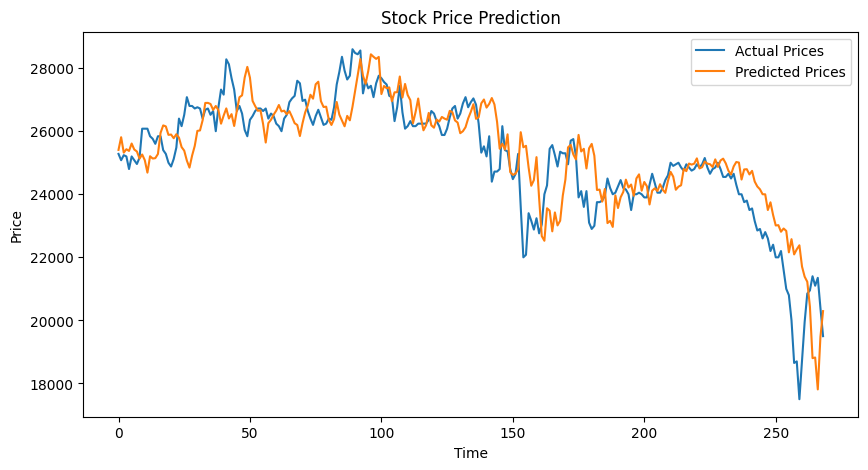

In [3]:
import matplotlib.pyplot as plt

# Khởi tạo một figure mới
fig = plt.figure(figsize=(10, 5))

# Trực quan hóa giá trị thực tế
plt.plot(y_test, label='Actual Prices')

# Trực quan hóa giá trị dự báo
plt.plot(y_pred, label='Predicted Prices')

# Thiết lập tiêu đề, nhãn trục x và y
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')

# Hiển thị chú thích
plt.legend()

# Hiển thị biểu đồ
plt.show()